In [45]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.patches import Rectangle
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import geopandas as gpd
from IPython.display import HTML # For Jupyter animation display

In [46]:
np.random.seed(42)  # For reproducibility
# Loading and preprocessing the dataset
data = pd.read_csv('decadal-average-death-rates-from-natural-disasters-2020-1.csv')
# print("Dataset preview:")
# print(data.head())

# Selecting the numeric features (the first three columns are non-numeric: Entity, Code, Year)
features = data.columns[3:]
X = data[features].values

# Normalizing the features between 0 and 1
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [47]:
# Implementation of the Self-Organizing Map (SOM)
class SOM:
    def __init__(self, m, n, dim, n_iterations=1000, init_lr=0.4):
        """
        m, n: dimensions of the SOM grid (e.g., 10 x 10)
        dim: dimensionality of the input feature vectors
        n_iterations: total number of training iterations
        init_lr: initial learning rate
        """
        self.m = m
        self.n = n
        self.dim = dim
        self.n_iterations = n_iterations
        self.init_lr = init_lr
        # Initial radius is half of the larger grid dimension.
        self.init_radius = max(self.m, self.n) / 2.0  
        self.time_constant = n_iterations / np.log(self.init_radius) # Compute time constant for exponential decay (used for decaying radius)
        # Initializing weights randomly between 0 and 1
        self.weights = np.random.rand(m, n, dim)
        # Creating grid coordinates
        self._init_grid()
    
    def _init_grid(self):
        # Creates a grid of coordinates for the SOM nodes.
        self.grid = np.array([[np.array([i, j]) for j in range(self.n)]
                              for i in range(self.m)])
    
    def _decay_radius(self, iteration): 
        # decaying radius exponnetially
        return self.init_radius * np.exp(-iteration / self.time_constant)
    
    def _decay_lr(self, iteration):
        # decaying learning rate exponentially
        return self.init_lr * np.exp(-iteration / self.n_iterations)
    
    def _find_bmu(self, x):
        #Finding the best matching unit (BMU) for input vector x using squared Euclidean distance.
        diff = self.weights - x   #shape: (m, n, dim)
        squared_diff = np.sum(diff ** 2, axis=2)
        bmu_index = np.unravel_index(np.argmin(squared_diff), (self.m, self.n))
        return bmu_index
    
    def update(self, x, bmu_idx, iteration):
        # Updating weights using a Gaussian neighborhood function.
        lr = self._decay_lr(iteration)           # Get decayed learning rate
        radius = self._decay_radius(iteration)     # Get decayed radius
        for i in range(self.m):
            for j in range(self.n):
                node_pos = np.array([i, j])        # Get grid position of node [i, j]
                # Compute the Euclidean distance (on the grid) from the node to the BMU
                distance = np.linalg.norm(node_pos - np.array(bmu_idx))
                if distance <= radius:
                    # The neighborhood function (Gaussian based on distance)
                    influence = np.exp(-distance**2 / (2 * (radius**2)))
                    # Update the weights: move them closer to the input vector, proportional to influence and learning rate
                    self.weights[i, j, :] += lr * influence * (x - self.weights[i, j, :])
    
    def train(self, data):
        # Training the SOM and storing snapshots at selected iterations.
        self.snapshots = []
        snapshot_indices = set(np.linspace(0, self.n_iterations-1, 10, dtype=int))
        # Ensure iteration 0 is included:
        snapshot_indices.add(0)
        
       # For each iteration of training:
        for it in range(self.n_iterations):
            # Select a random input vector from the dataset
            x = data[np.random.randint(0, data.shape[0])]
            # Find the BMU for that input
            bmu_idx = self._find_bmu(x)
            # Update the weights based on the input vector
            self.update(x, bmu_idx, it)
            # If this iteration is one of our snapshots, store a copy of the weights
            if it in snapshot_indices:
                self.snapshots.append((it, self.weights.copy()))
            # Print progress every 100 iterations
            # if (it+1) % 100 == 0:
            #     print(f"Iteration {it+1}/{self.n_iterations} complete.")
    
    def map_vects(self, data):
        # Mapping each input sample to its BMU coordinates.
        mapping = []
        for x in data:
            bmu_idx = self._find_bmu(x)
            mapping.append(bmu_idx)
        return mapping

# Defining SOM parameters:

grid_size = 10        # 10x10 grid
n_iterations = 5000   # training iterations
init_lr = 0.3        # initial learning rate

# Creating SOM instance; input dimension equals number of features
som = SOM(m=grid_size, n=grid_size, dim=X_scaled.shape[1], n_iterations=n_iterations, init_lr=init_lr)

# Training the SOM and saving snapshots for visualization
# print("Training SOM...")
som.train(X_scaled)
# print("Training completed.")

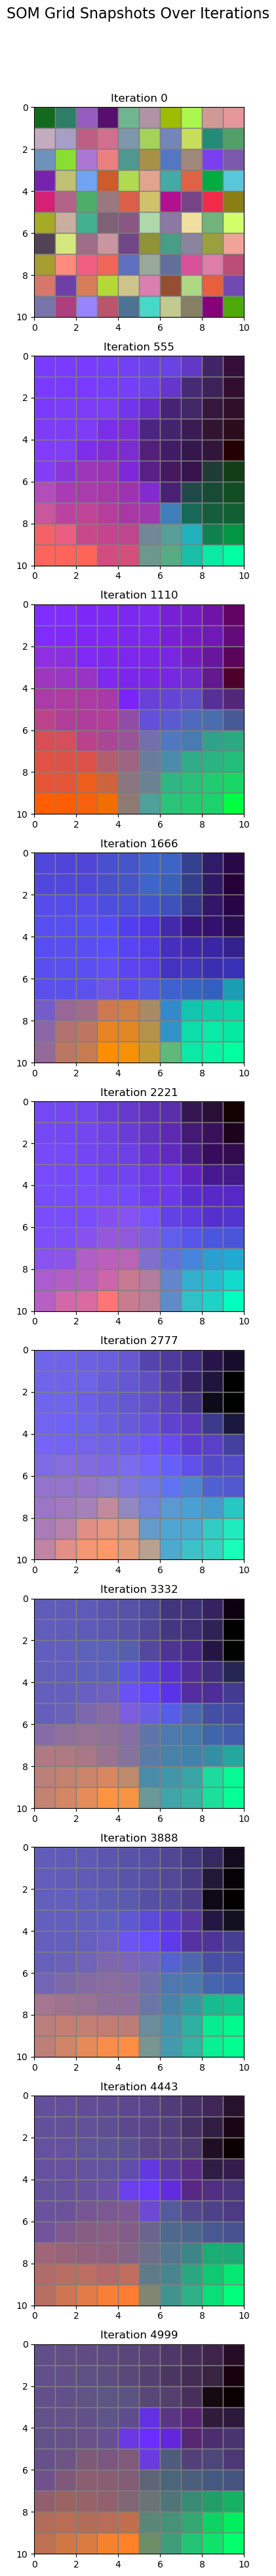

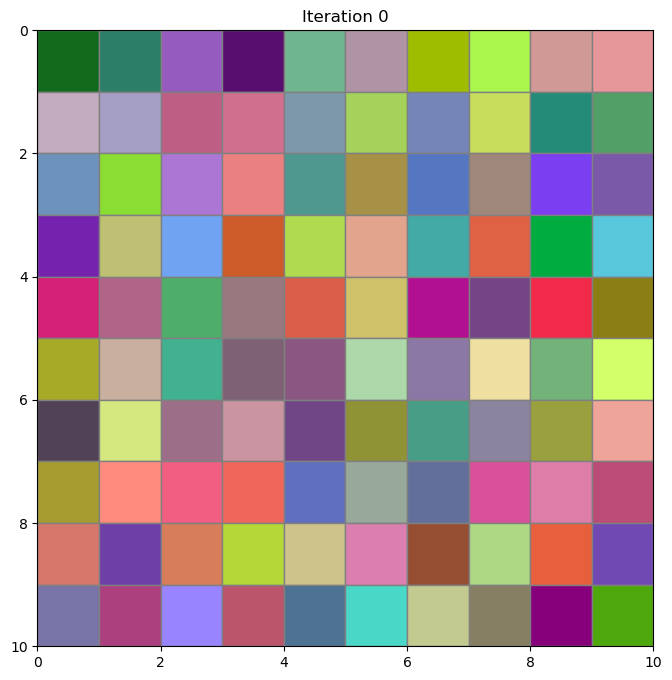

In [48]:
# Visualizing the SOM grid snapshots

# Using PCA to reduce weight vectors to three components (for RGB mapping)
weights_reshaped = som.weights.reshape(-1, X_scaled.shape[1])
pca = PCA(n_components=3)
pca.fit(weights_reshaped)

def weights_to_rgb(weights):
    w_reshaped = weights.reshape(-1, X_scaled.shape[1])
    w_pca = pca.transform(w_reshaped)
    # Normalizing to range [0,1]
    w_pca_norm = MinMaxScaler().fit_transform(w_pca)
    w_pca_clipped = np.clip(w_pca_norm, 0, 1)  # Ensures all values are in [0, 1]
    return w_pca_clipped.reshape(som.m, som.n, 3)

# Arranging snapshots vertically (one column)
num_snapshots = len(som.snapshots)
fig_snap, axes = plt.subplots(nrows=num_snapshots, ncols=1, figsize=(4, 4*num_snapshots))

# Ensuring axes are always iterable.
if num_snapshots == 1:
    axes = [axes]

for ax, (it, weights_snapshot) in zip(axes, som.snapshots):
    rgb_grid = weights_to_rgb(weights_snapshot)
    # Clear the axis (in case there is any previous content)
    ax.clear()
    # Draw each grid cell as a rectangle with the corresponding color
    for i in range(som.m):
        for j in range(som.n):
            color = rgb_grid[i, j]
            rect = Rectangle((j, i), 1, 1, facecolor=color, edgecolor='gray')
            ax.add_patch(rect)
    ax.set_title(f"Iteration {it}")
    ax.set_xlim(0, som.n)
    ax.set_ylim(0, som.m)
    ax.set_aspect('equal')
    ax.invert_yaxis()

plt.suptitle("SOM Grid Snapshots Over Iterations", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Animating the SOM grid evolution
fig_anim, ax_anim = plt.subplots(figsize=(8, 8))
ax_anim.set_xlim(0, som.n)
ax_anim.set_ylim(0, som.m)
ax_anim.invert_yaxis()
ax_anim.set_aspect('equal')

def animate_func(frame):
    it, weights_snapshot = som.snapshots[frame]
    rgb_grid = weights_to_rgb(weights_snapshot)
    ax_anim.clear()
    ax_anim.set_xlim(0, som.n)
    ax_anim.set_ylim(0, som.m)
    ax_anim.invert_yaxis()
    ax_anim.set_aspect('equal')
    for i in range(som.m):
        for j in range(som.n):
            color = rgb_grid[i, j]
            rect = Rectangle((j, i), 1, 1, facecolor=color, edgecolor='gray')
            ax_anim.add_patch(rect)
    ax_anim.set_title(f"Iteration {it}")

# Assigning an animation object to a variable that remains in scope.
anim = animation.FuncAnimation(fig_anim, animate_func, frames=len(som.snapshots), interval=500)
# Rendering the animation explicitly in Jupyter Notebook.
HTML(anim.to_jshtml())

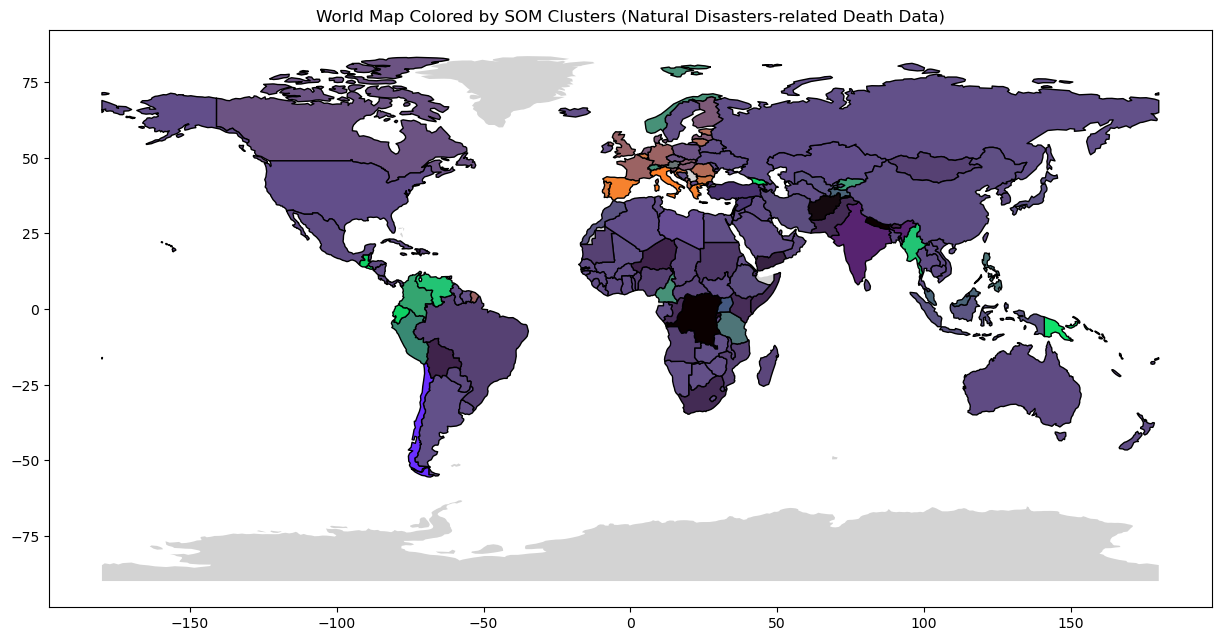

In [49]:
# Mapping countries on a world map using SOM cluster colors

country_bmu = som.map_vects(X_scaled) # Mapping each data sample (country) to its BMU on the SOM grid.
bmu_coords = [f"{idx[0]}-{idx[1]}" for idx in country_bmu] # Converting BMU indices into a string format "row-column" for later reference.

rgb_final = weights_to_rgb(som.weights) # Converting the final SOM weights to RGB for assigning a color to each node
country_colors = []
# Looping over each data sample's BMU and assign the corresponding color as a hex string.
for idx in country_bmu:
    i, j = idx
    rgb = (rgb_final[i, j] * 255).astype(int)  # Scale RGB from [0,1] to [0,255]
    country_colors.append('#{:02x}{:02x}{:02x}'.format(rgb[0], rgb[1], rgb[2]))

# Create a result DataFrame mapping each country (Entity) to its BMU and color.
result_df = data[['Entity', 'Code']].copy()
result_df['BMU'] = bmu_coords
result_df['Color'] = country_colors
# print("Country BMU and colors:")
# print(result_df)

# Loading the world map directly from a local shapefile
world = gpd.read_file("ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")
# Normalizing the country names to lowercase for matching:
result_df['Entity_clean'] = result_df['Entity'].str.lower()
world['name_clean'] = world['ADMIN'].str.lower()

# Merging result DataFrame with the world GeoDataFrame on the normalized country names.
merged = world.merge(result_df, left_on='name_clean', right_on='Entity_clean', how='left')

fig_map, ax_map = plt.subplots(1, 1, figsize=(15, 10))
world.plot(ax=ax_map, color='lightgray')  # Base map
merged.dropna(subset=['Color']).plot(ax=ax_map, color=merged.dropna(subset=['Color'])['Color'], edgecolor='black')
ax_map.set_title("World Map Colored by SOM Clusters (Natural Disasters-related Death Data)")
plt.show()